In [212]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.io import netcdf
from shapely.geometry import Point
from sklearn.neighbors import BallTree

## Geographically visualise datapoints

In [5]:
# read data from netcdf files

file2read_2015 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2015.nc','r')
file2read_2016 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2016.nc','r')
file2read_2017 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2017.nc','r')
file2read_2018 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2018.nc','r')
file2read_2019 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2019.nc','r')

temp_2015 = file2read_2015.variables["dis24"]
temp_2016 = file2read_2016.variables["dis24"]
temp_2017 = file2read_2017.variables["dis24"]
temp_2018 = file2read_2018.variables["dis24"]
temp_2019 = file2read_2019.variables["dis24"]

/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_64108/2496670625.py:3: DeprecationWarning: `scipy.io.netcdf.NetCDFFile` is deprecated along with the `scipy.io.netcdf` namespace. `scipy.io.netcdf.NetCDFFile` will be removed in SciPy 1.14.0, and the `scipy.io.netcdf` namespace will be removed in SciPy 2.0.0.
  file2read_2015 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2015.nc','r')
/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_64108/2496670625.py:4: DeprecationWarning: `scipy.io.netcdf.NetCDFFile` is deprecated along with the `scipy.io.netcdf` namespace. `scipy.io.netcdf.NetCDFFile` will be removed in SciPy 1.14.0, and the `scipy.io.netcdf` namespace will be removed in SciPy 2.0.0.
  file2read_2016 = netcdf.NetCDFFile('../data/yearly_discharge/discharge_2016.nc','r')
/var/folders/88/dz760h_j197bwmcvghz9mrkh0000gn/T/ipykernel_64108/2496670625.py:5: DeprecationWarning: `scipy.io.netcdf.NetCDFFile` is deprecated along with the `scipy.io.netcdf` namespace.

In [6]:
# select longitude and latitude
lon_values = file2read_2015.variables["lon"][:]
lat_values = file2read_2015.variables["lat"][:]

In [7]:
# preprocessing

data_2015 = temp_2015[:]*1
data_2016 = temp_2016[:]*1
data_2017 = temp_2017[:]*1
data_2018 = temp_2018[:]*1
data_2019 = temp_2019[:]*1

data_2015[data_2015==1e20] = np.nan
data_2016[data_2016==1e20] = np.nan
data_2017[data_2017==1e20] = np.nan
data_2018[data_2018==1e20] = np.nan
data_2019[data_2019==1e20] = np.nan

## just 2015

In [260]:
import xarray as xr

# Open the netCDF file using xarray
data_2015 = xr.open_dataset('../data/yearly_discharge/discharge_2015.nc')

# Convert the xarray Dataset to a pandas DataFrame
df = data_2015.to_dataframe()

# Reset the index to flatten the multi-index DataFrame
df.reset_index(inplace=True)

# drop missing
df.replace(1e20, np.nan, inplace=True)
df.dropna(inplace=True)

# to_plot = df[df['time']=='2015-01-01']
# to_plot

#### map

In [261]:
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

geo_df = gpd.GeoDataFrame(df, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,time,lon,lat,dis24,geometry
0,2015-01-01,60.05,37.95,0.000119,POINT (60.05000 37.95000)
1,2015-01-01,60.05,37.85,0.001098,POINT (60.05000 37.85000)
2,2015-01-01,60.05,37.75,0.000071,POINT (60.05000 37.75000)
3,2015-01-01,60.05,37.65,0.000046,POINT (60.05000 37.65000)
4,2015-01-01,60.05,37.55,0.000217,POINT (60.05000 37.55000)


<Axes: >

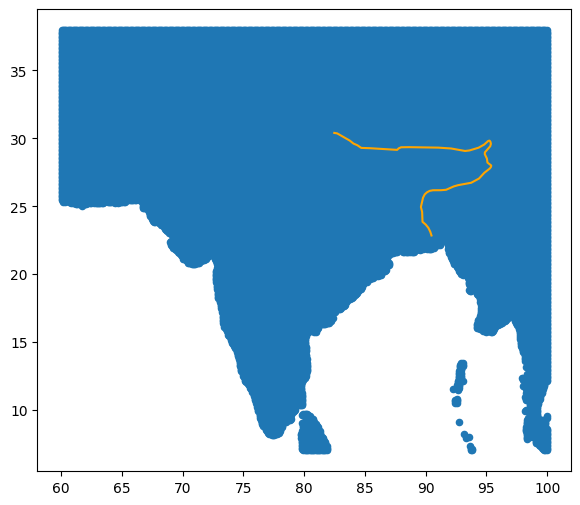

In [262]:
fig, ax = plt.subplots(figsize=(13,6))

river_map = gpd.read_file('../data/centerlines_data/ne_110m_rivers_lake_centerlines.shp')
brahmaputra = river_map[river_map['name'] == 'Brahmaputra']

geo_df[geo_df['time']=='2015-01-01'].plot(ax=ax, markersize=20, marker='o')
brahmaputra.plot(ax=ax, color='orange')

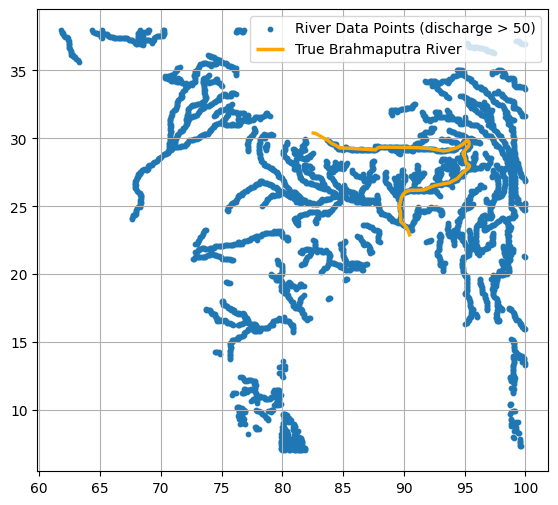

In [263]:
fig, ax = plt.subplots(figsize=(13,6))

geo_df[(geo_df['time']=='2015-01-01') & (geo_df['dis24'] > 30)].plot(ax=ax, markersize=10, marker='o', label='River Data Points (discharge > 50)')
brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River')

plt.legend()
plt.grid(True)

add other rivers to the plot in another colour 

axes, labels 

other features? 

In [264]:
geo_df.shape

(28375830, 5)

In [265]:
river_linestring = brahmaputra.iloc[0]['geometry']
river_points = list(river_linestring.coords)
min(river_points), max(river_points)

## do this to also check for second lat values (could reduce size of data)

((82.40047977084697, 30.411477362585146),
 (95.39648237506563, 28.002916368109368))

In [266]:
dis_threshold = 30  # Define threshold for "close to zero" (using above plot)
mask = (geo_df['dis24'].abs() > dis_threshold) & (geo_df['lon'] > 82) & (geo_df['lon'] < 96) & (geo_df['lat'] > 22) & (geo_df['lat'] < 31)
filtered_df = geo_df[mask]

In [267]:
filtered_df.shape

(894368, 5)

In [268]:
# Function to calculate distance between two points
def calculate_distance(point1, point2):
    return point1.distance(point2)

In [269]:
# Create an empty DataFrame to store the closest points
closest_points = pd.DataFrame(columns=filtered_df.columns)

# Iterate over each unique day in the 'time' column
for day, one_day_data in filtered_df.groupby(filtered_df['time'].dt.to_period('D')):
    # Create a BallTree for the current day's data
    tree = BallTree(one_day_data['geometry'].apply(lambda x: [x.coords[0][0], x.coords[0][1]]).tolist())
    
    # Find the closest points in one_day_data to each point in river_points
    for true_coord in river_points:
        true_point = Point(true_coord)
        _, ind = tree.query([[true_point.x, true_point.y]], k=5)  # Find 5 nearest neighbors
        
        # Check if ind array is not empty
        if len(ind) > 0:
            # Choose the closest point among the 5 nearest neighbors
            min_distance = float('inf')
            closest_row = None

            for i in ind[0]:
                distance = calculate_distance(one_day_data.iloc[i]['geometry'], true_point)
                if distance < min_distance:
                    min_distance = distance
                    closest_row = one_day_data.iloc[i]
            
            #closest_points = closest_points.append(closest_row, ignore_index=True)
            closest_points.loc[len(closest_points.index)] = closest_row

In [270]:
closest_points['time'] = pd.to_datetime(closest_points['time'])
closest_points['time'] = closest_points['time'].dt.date
closest_points

,time,lon,lat,dis24,geometry
0,2015-01-01,81.85,29.95,35.41198,POINT (81.85000000000002 29.950000000000003)
1,2015-01-01,81.85,29.95,35.41198,POINT (81.85000000000002 29.950000000000003)
2,2015-01-01,83.75,29.85,31.251619,POINT (83.75 29.85)
3,2015-01-01,84.05,29.55,40.950394,POINT (84.05000000000001 29.549999999999997)
4,2015-01-01,84.35,29.55,44.086777,POINT (84.35000000000002 29.549999999999997)
...,...,...,...,...,...
17515,2015-12-31,89.65,23.85,4844.755371,POINT (89.65000000000003 23.849999999999994)
17516,2015-12-31,89.95,23.65,7257.498535,POINT (89.95000000000005 23.650000000000006)
17517,2015-12-31,90.25,23.45,7326.676758,POINT (90.25 23.450000000000003)
17518,2015-12-31,90.55,23.25,7401.643555,POINT (90.55000000000001 23.25)


In [275]:
geo_points = gpd.GeoDataFrame(closest_points, 
                              crs=crs, 
                              geometry=closest_points['geometry'])

In [290]:
geo_points.head()

,time,lon,lat,dis24,geometry
0,2015-01-01,81.85,29.95,35.41198,POINT (81.85000 29.95000)
1,2015-01-01,81.85,29.95,35.41198,POINT (81.85000 29.95000)
2,2015-01-01,83.75,29.85,31.251619,POINT (83.75000 29.85000)
3,2015-01-01,84.05,29.55,40.950394,POINT (84.05000 29.55000)
4,2015-01-01,84.35,29.55,44.086777,POINT (84.35000 29.55000)


In [292]:
print(geo_points['time'].unique())

[datetime.date(2015, 1, 1) datetime.date(2015, 1, 2)
 datetime.date(2015, 1, 3) datetime.date(2015, 1, 4)
 datetime.date(2015, 1, 5) datetime.date(2015, 1, 6)
 datetime.date(2015, 1, 7) datetime.date(2015, 1, 8)
 datetime.date(2015, 1, 9) datetime.date(2015, 1, 10)
 datetime.date(2015, 1, 11) datetime.date(2015, 1, 12)
 datetime.date(2015, 1, 13) datetime.date(2015, 1, 14)
 datetime.date(2015, 1, 15) datetime.date(2015, 1, 16)
 datetime.date(2015, 1, 17) datetime.date(2015, 1, 18)
 datetime.date(2015, 1, 19) datetime.date(2015, 1, 20)
 datetime.date(2015, 1, 21) datetime.date(2015, 1, 22)
 datetime.date(2015, 1, 23) datetime.date(2015, 1, 24)
 datetime.date(2015, 1, 25) datetime.date(2015, 1, 26)
 datetime.date(2015, 1, 27) datetime.date(2015, 1, 28)
 datetime.date(2015, 1, 29) datetime.date(2015, 1, 30)
 datetime.date(2015, 1, 31) datetime.date(2015, 2, 1)
 datetime.date(2015, 2, 2) datetime.date(2015, 2, 3)
 datetime.date(2015, 2, 4) datetime.date(2015, 2, 5)
 datetime.date(2015, 2, 

In [299]:
geo_points['time'] = pd.to_datetime(geo_points['time'])
january_data = geo_points[(geo_points['time'].dt.month == 1)]

<Axes: >

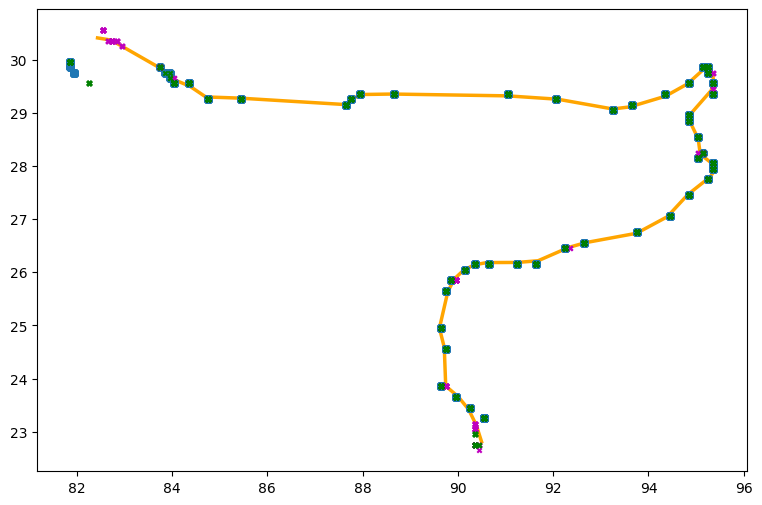

In [305]:
fig, ax = plt.subplots(figsize=(13, 6))

brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)
#geo_points.plot(ax=ax, markersize=10, marker='o', label='Data Points Jan 2015')

january_data = geo_points[(geo_points['time'].dt.month == 1)]
january_data.plot(ax=ax, markersize=30, marker='o', label='One Day Points Jan 2015')

aug_data = geo_points[(geo_points['time'].dt.month == 8)]
aug_data.plot(ax=ax, markersize=10, marker='x', color='m', label='One Day Points Aug 2015')

nov_data = geo_points[(geo_points['time'].dt.month == 11)]
nov_data.plot(ax=ax, markersize=10, marker='x', color='g', label='One Day Points Aug 2015')


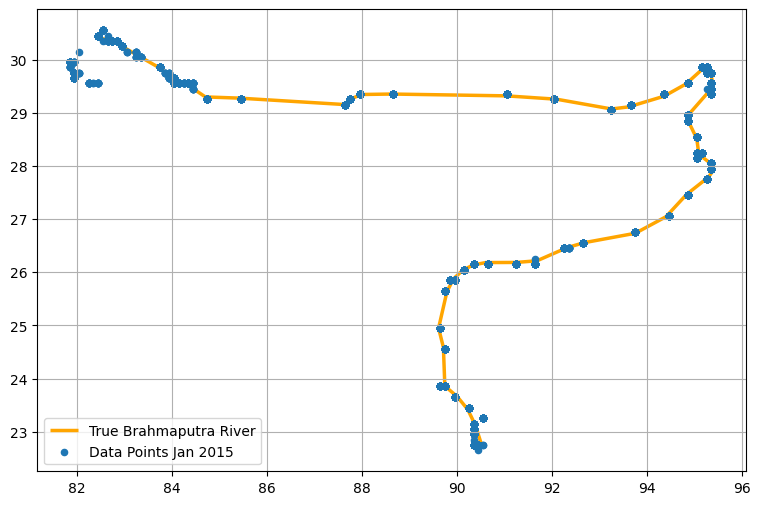

In [271]:
# closest_points['geometry'].plot(ax=ax, markersize=20, marker='o', label='Data Points Jan 2015', zorder=1)
# closest_points[closest_points['time']=='2016-01-01'].plot(ax=ax, markersize=20, marker='o', label='Data Points Jan 2016', zorder=2)
# closest_points[closest_points['time']=='2017-01-01'].plot(ax=ax, markersize=20, marker='o', label='Data Points Jan 2017', zorder=3)
# closest_points[closest_points['time']=='2018-01-01'].plot(ax=ax, markersize=20, marker='o', label='Data Points Jan 2018', zorder=4)
# closest_points[closest_points['time']=='2019-01-01'].plot(ax=ax, markersize=20, marker='o', label='Data Points Jan 2019', zorder=5)


# Extract coordinates from the geometry column
x_coords = closest_points['geometry'].apply(lambda point: point.x)
y_coords = closest_points['geometry'].apply(lambda point: point.y)

# Plot the points
fig, ax = plt.subplots(figsize=(13, 6))

brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)
ax.scatter(x_coords, y_coords, s=20, marker='o', label='Data Points Jan 2015', zorder=1)

plt.legend(loc='lower left')
plt.grid(True)

In [235]:
# Open the netCDF file using xarray
data_2015 = xr.open_dataset('../data/yearly_discharge/discharge_2015.nc')

# Convert the xarray Dataset to a pandas DataFrame
df = data_2015.to_dataframe()

# Reset the index to flatten the multi-index DataFrame
df.reset_index(inplace=True)

# drop missing
df.replace(1e20, np.nan, inplace=True)
df.dropna(inplace=True)

to_plot = df[df['time']=='2015-01-01']

crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(to_plot['lon'], to_plot['lat'])]

geo_df = gpd.GeoDataFrame(to_plot, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

dis_threshold = 30  # Define threshold for "close to zero" (using above plot)
mask = (geo_df['dis24'].abs() > dis_threshold) & (geo_df['lon'] > 81) & (geo_df['lon'] < 96) & (geo_df['lat'] > 22) & (geo_df['lat'] < 31)
filtered_df = geo_df[mask]

/Users/smart/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [236]:
# Convert river to a list of individual points (lon, lat)
river_linestring = brahmaputra.iloc[0]['geometry']
river_points = list(river_linestring.coords)

# Create a list to store the closest points
closest_points = []

# Iterate over each true coordinate in river_points
for true_coord in river_points:
    true_point = Point(true_coord)
    min_distance = float('inf')  # Initialise with infinity
    closest_point = None
    
    # Iterate over each row in filtered_df
    for index, row in filtered_df.iterrows():
        # Check if the 'geometry' column contains a valid geometry object
        if not pd.isna(row['geometry']):
            # Calculate distance between true_point and row's geometry
            distance = calculate_distance(row['geometry'], true_point)
            # Check if this distance is smaller than the current minimum
            if distance < min_distance:
                min_distance = distance
                closest_point = index  # Store the index of the closest row
    
    # Append the index of the closest point to the list
    closest_points.append(closest_point)

# Filter out only the rows with closest points
one_day_filtered_2015 = filtered_df.loc[closest_points]

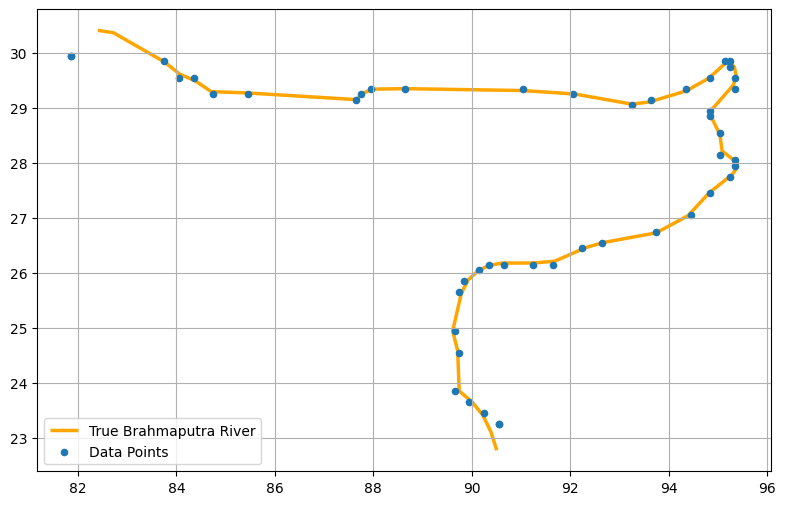

In [238]:
fig, ax = plt.subplots(figsize=(13,6))

brahmaputra.plot(ax=ax, color='orange', linewidth=2.5, label='True Brahmaputra River', zorder=0)
one_day_filtered_2015[one_day_filtered_2015['time']=='2015-01-01'].plot(ax=ax, markersize=20, marker='o', label='Data Points', zorder=1)

plt.legend()
plt.grid(True)

In [240]:
monthly_filtered_2015.shape

(48, 5)

In [145]:
# not saved to data folder, which is in gitignore
monthly_filtered_2015.to_csv('../river_data.csv', index=False)